# Imports

In [106]:
#@title General
import numpy as np
import pandas as pd
import random as r
import itertools
import math
import matplotlib.pyplot as plt
import copy
import math

# Parameters

Em geral, todos parâmetros para mudar o tuning do programa então aqui. (E na função Score)

All relevant parameters to change the tuning of the program are here. (And in the Score function)

In [107]:
#@title Gerais

# general parameters
nStd = 250 # number of Students
nTch = 100 # number of Referees
nWrd = 30 # number of words
reductedDim = 5 # reducted dimension of SVD (< 100)

# parametros de busca
insideloop = 10 # number of modification in each iteration of the stocastic search
outsideloop = 1000 # number of steps in the search

In [108]:
#@title Allocation Params
quant_av_std = 3 # number of referees for each student
quant_av_tch = math.ceil(nStd * quant_av_std / nTch) #general max of student per referee

In [109]:
#@title Parameter for artificial data

nG = 5 # number of groups participants belong to (students and referees)
spG = nStd // nG # student per group
tpG = nTch // nG # referees per group

# add some noise to increase connections between groups
noise = 0.9 # (0-1) 1 is none noise
related = 0.2 # how related in group (0 is most)

nRel = 100 # number of possible orientations

# proportion of each class of students and referees we want to generate
propstds = (1,1,1) # proportion (phd, master, undergrad)
proprefs = (1,1,1) # proportion (teacher, researcher, phd)

# Classes

Algumas classes que serão úteis para manter a ordem durante o seguimento do código. Referee e Student são extensões de Participant.

Some classes that will be useful to keep the order during the code follow-up. Referee and Student are extensions of Participant.

In [110]:
#@title Participant

class Participant:
    identity = itertools.count()
    def __init__(self, name, words):
        self.name = name # name of participant
        self.words = words # vectors of 1's and 0's for existing or non existing word
        self.id = next(self.identity) # id of this participant
        self.LatentRepr = None # latent representation in space of projection of SVD
        self.allocated = [] # wich were allocated (both students or referees)
        self.section = [] # section of student

    def __str__(self):
        return self.name # get name

    def __eq__(self, other):
        return self.id == other.id # compare two participants

    # Latent Represatation
    def setLatentRepr(self, LatentRepr):
        if type(LatentRepr) == np.ndarray:
            self.LatentRepr = LatentRepr / np.linalg.norm(LatentRepr)
        else:
            raise ValueError('Latent representation must be a numpy array')

    # Relation between two vectors of latent repr
    def relation(self, other):
        if self.LatentRepr is not None and other.LatentRepr is not None:
            # return normalized angle between vectors
            return np.dot(self.LatentRepr, other.LatentRepr)
        else:
            raise ValueError('Latent representation not set')

In [111]:
#@title Referee
#@title Referee
class Referee(Participant):

    def __init__(self, name, words, typeRef, maxStd):
        super().__init__(name, words)
        self.type = typeRef # type of referee
        self.supervisedStds = [] # wich students are supervised
        self.maxStudents = maxStd

    # add a Student as supervised
    def addSupervisedStd(self, std):
        if isinstance(std, Student):
            if std not in self.supervisedStds:
                self.supervisedStds.append(std)
            else:
                raise ValueError('Student already in the list')
        else:
            raise ValueError('Supervised student must be a student')

    # get type of referee
    def gettypeRef(self):
        if self.type == 0:
            return 'Professor'
        elif self.type == 1:
            return 'Researcher'
        elif self.type == 2:
            return 'PhD-Student'
        else:
            raise ValueError('Unknown type of referee')

    def __str__(self):
        return 'Referee ' + super().__str__() + ' - ' + self.gettypeRef()

    def addSection(self, secNumber, std):
        if isinstance(std, Student):
            self.section.append([secNumber, std])
        else:
            raise ValueError('Student not a Student')

In [112]:
#@title Student
class Student(Participant):

    def __init__(self, name, words, typeStd, pypm = False):
        super().__init__(name, words)
        self.type = typeStd # type of Student
        self.pypm = pypm # is in pypm
        self.supervisers = [] # wich superviders

    # add superviser to student
    def addSuperviser(self, superviser):
        if isinstance(superviser, Referee):
            if superviser not in self.supervisers:
                self.supervisers.append(superviser)
            else:
                raise ValueError('Superviser already in the list')
        else:
            raise ValueError('Superviser must be a referee')

    # get type of student
    def gettypeStd(self):
        if self.type == 0:
            return 'PhD-Student'
        elif self.type == 1:
            return 'Master-Student'
        elif self.type == 2:
            return 'Undergraduate-Student'
        else:
            raise ValueError('Unknown type of student')

    # allocate ref to std
    def allocate(self, ref):
        if isinstance(ref, Referee):
            if ref not in self.allocated:
                self.allocated.append(ref)
                ref.allocated.append(self)
            else:
                raise ValueError('Student already allocated')
        else:
            raise ValueError('Allocated student must be a Referee')

    # deallocate ref of std
    def deallocate(self, ref):
        if isinstance(ref, Referee):
            if ref in self.allocated:
                if self in ref.allocated:
                    self.allocated.remove(ref)
                    ref.allocated.remove(self)
                else:
                    raise ValueError('Student not even allocated in the referee')
            else:
                raise ValueError('Teacher not even allocated in the student')
        else:
            raise ValueError('Allocated student must be a Referee')

    def __str__(self):
        return 'Student ' + super().__str__() + ' - ' + self.gettypeStd()

    def addSection(self, secNumber, ref):
        if isinstance(ref, Referee):
            self.section.append(secNumber)
            ref.addSection(secNumber, self)
        else:
            raise ValueError('Referee not a Referee')

# Simulate Data

In [113]:
#@title Simulate Data

# We will simply instantiate a number of students and referees with random words based on its group and noise

wpg = nWrd // nG
# Students
Stds = [Student('S' + str(i) + ' G' + str(i // spG), np.array([int(r.random() > noise) for _ in range((i//spG)*wpg)] + [int(r.random() > related) for _ in range(wpg)] + [int(r.random() > noise) for _ in range(nWrd - ((i//spG)+1)*wpg)]), r.sample([0] * propstds[0] +[1] * propstds[1] +[2] * propstds[2], 1)[0]) for i in range(nStd)]
# Teachers
Tchs = [Referee('R' + str(i) + ' G' + str(i // tpG), np.array([int(r.random() > noise) for _ in range((i//tpG)*wpg)] + [int(r.random() > related) for _ in range(wpg)] + [int(r.random() > noise) for _ in range(nWrd - ((i//tpG)+1)*wpg)]), r.sample([0] * proprefs[0] +[1] * proprefs[1] +[2] * proprefs[2], 1)[0], quant_av_tch) for i in range(nTch)]


# SVD

In [114]:
#@title Run SVD

# We need a matrix of Students words and a matrix of teachers words
stdsMatrix = np.array([Stds[i].words for i in range(nStd)]).T
tchsMatrix = np.array([Tchs[i].words for i in range(nTch)]).T

# SVD decomposition of the students in reducted dimension
Uo, So, Vo = np.linalg.svd(stdsMatrix)
Uo = Uo[:, :reductedDim] 
So = So[:reductedDim] 
Vo = Vo[:reductedDim, :]

In [115]:
#@title Latent Representation
# Project the teachers into the space U
TchsProj = np.dot(Uo.T, tchsMatrix)
StdsProj = np.dot(Uo.T, stdsMatrix)
TchsProj = TchsProj.T
StdsProj = StdsProj.T

# set latent representation in U for Stds
count = 0
for std in Stds:
    std.setLatentRepr(StdsProj[count])
    count += 1
# set latent representation in U for tchs
count = 0
for tch in Tchs:
    tch.setLatentRepr(TchsProj[count])
    count += 1

# Correlation


In [116]:
#@title Calculate Correlation Matrix

# Calculate the correlation matrix with the angle using LatentRepr
Corr = [[Tchs[i].relation(Stds[j]) for i in range(nTch)] for j in range(nStd)]

In [117]:
#@title Save File
# write in file the correlation matrix
df = pd.DataFrame(Corr)
# put the index and header
df.index = [str(Stds[i]) for i in range(nStd)]
df.columns = [str(Tchs[i]) for i in range(nTch)]
# write in file
df.to_csv('Corr.csv', index=True, header=True)

# Allocate

In [118]:
#@title Impose Rules

RulesMatrix = np.array([[True for _ in range(nTch)] for _ in range(nStd)])

# create random relations between students and teachers
for i in range(nRel):
    istd = r.randint(0, nStd-1)
    itch = r.randint(0, nTch-1)
    if len(Stds[istd].supervisers) < 1:
        Stds[istd].addSuperviser(Tchs[itch])
        Tchs[itch].addSupervisedStd(Stds[istd])
    else:
        continue

# add student and his supervisors
for std in Stds:
    for tch in std.supervisers:
        RulesMatrix[Stds.index(std)][Tchs.index(tch)] = False

# referees of type 2 can't avaliate students of type 0 or 1
for tch in Tchs:
    if tch.type == 2:
        for std in Stds:
            if std.type == 0 or std.type == 1:
                RulesMatrix[Stds.index(std)][Tchs.index(tch)] = False

In [119]:
#@title Save File

#write ALlocMatrix in file
df = pd.DataFrame(RulesMatrix)
# put the index and header
df.index = [str(Stds[i]) for i in range(nStd)]
df.columns = [str(Tchs[i]) for i in range(nTch)]
# write in file
df.to_csv('RulesMatrix.csv', index=True, header=True)

In [120]:
#@title General Allocation
# we need to create a matrix of allocation with the following rules:
# 1. Each student must have quant_av_std referees (each line must have quant_av_std 1's)
# 2. Each teacher must have the between quant_av_tch and quant_av_tch+1 students (each column must have between quant_av_tch and quant_av_tch+1 1's)
# 3. The rulesMatrix must be respected (each 0 in the rulesMatrix must be 0 in the allocation matrix)

# create the matrix of allocation
AllocMatrix = np.array([[0 for _ in range(nTch)] for _ in range(nStd)])

ref_allocated = [0 for _ in range(nTch)]
std_allocated = [0 for _ in range(nStd)]

# allocate referees of type 0 and 1 to the students of type 0 and 1
for i in range(nStd):
    if Stds[i].type == 0 or Stds[i].type == 1:
        # get all that can be allocated
        tofill = [j for j in range(nTch) if ref_allocated[j] < Tchs[j].maxStudents]
        # get all with type 0 or 1
        typeId = [j for j in range(nTch) if Tchs[j].type == 0 or Tchs[j].type == 1]
        # based on all above + rules
        tchsIdx = [j for j in range(nTch) if RulesMatrix[i][j] and j in tofill and j in typeId]
        # if there is no one to allocate, keep going but skip this student
        if len(tchsIdx) < quant_av_std:
            print('Warning: not enough referees for student ' + str(i) + ' of type ' + str(Stds[i].type) + ' to allocate')
            continue
        # select randomly
        tchsIdx.sort(key=lambda x: ref_allocated[x])
        tchsIdx = tchsIdx[:quant_av_std]
        # allocate
        for j in tchsIdx:
            AllocMatrix[i][j] = 1
            ref_allocated[j] += 1
            std_allocated[i] += 1

# allocate the rest
for i in range(nStd):
    if std_allocated[i] < quant_av_std:
        howmany = quant_av_std - std_allocated[i]
        # get all that can be allocated
        tofill = [j for j in range(nTch) if ref_allocated[j] < Tchs[j].maxStudents]
        # based on all above + rules
        tchsIdx = [j for j in range(nTch) if RulesMatrix[i][j] and j in tofill]
        # if there is no one to allocate, break
        if len(tchsIdx) < howmany:
            print('Error: Really not enough referees for student ' + str(i) + ' of type ' + str(Stds[i].type) + ' to allocate')
            continue
        # select randomly
        tchsIdx.sort(key=lambda x: ref_allocated[x])
        tchsIdx = tchsIdx[:howmany]
        # allocate
        for j in tchsIdx:
            AllocMatrix[i][j] = 1
            ref_allocated[j] += 1
            std_allocated[i] += 1

In [121]:
#@title Save File
#write ALlocMatrix in file
df = pd.DataFrame(AllocMatrix)
# put the index and header
df.index = [str(Stds[i]) for i in range(nStd)]
df.columns = [str(Tchs[i]) for i in range(nTch)]
# write in file
df.to_csv('AllocMatrix.csv', index=True, header=True)

# Matching


A função de Score avalia a qualidade de uma iteração sobre a matriz de alocação. Da presente forma ela toma o vetor soma das linhas da (matriz de correlação * matriz de seleção). Ou seja, somente das celulas da matiz de correlação que foram selecionadas como 1 na atribuição.

Com este vetor, queremos homogeinizar as linhas, logo usamos a variancia dos termos deste vetor como um ponto que aumenta o score (quanto menor, melhor). O outro paramêtro é a dissociação desse vetor à um vetor 'ideal' que cada entrada seria a soma da correlação em cada uma das n avaliações feitas. Essa distancia é melhor quando grande (mesma direção).

alpha e beta são parametros para dizer o quanto nos importamos com cada um dos critérios.


In [122]:
#@title Function Score
def scoreMatrix(vec):
    # parameter of the score
    alpha = 3
    beta = 5
    idealVector = np.array([3 for _ in range(nStd)]) / np.linalg.norm(np.array([3 for _ in range(nStd)]))

    # calcute the variance of the score
    var = np.var(vec)

    # normalize the vector
    vec = vec / np.linalg.norm(vec)
    # calculate the dot product with the vector of 3's
    dot = np.dot(vec, idealVector)

    # calculate the score
    score = alpha*var - beta*dot

    return score, var, dot

In [123]:
#@title Run Random Iterations
vectorSoma = [sum([Corr[s][t] * AllocMatrix[s][t] for t in range(nTch)]) for s in range(nStd)]
score, var, dot = scoreMatrix(vectorSoma)
SellectedMatrixBest = copy.deepcopy(AllocMatrix)

#plot score
scorePlot = [score]
#plot variance
varPlot = [var]
#plot dot
dotPlot = [dot]

for loop in range(outsideloop):
    # copy the matrix
    SellectedMatrix = copy.deepcopy(SellectedMatrixBest)

    for _ in range(insideloop):
        # select a random referee
        selected_ref = r.randint(0, nTch-1)

        # select between the students that he has, the least compatible corr
        Least_std = min([Corr[s][selected_ref] for s in range(nStd) if SellectedMatrix[s][selected_ref] == 1], default=-10)
        if Least_std == -10:
          continue
        # index of the least compatible students
        idx = [s for s in range(nStd) if (Corr[s][selected_ref] == Least_std and SellectedMatrix[s][selected_ref] == 1)]
        # select first compatible students
        selected_std = idx[0]

        # for this student, select the most compatible referee
        Most_tch = max([Corr[selected_std][t] for t in range(nTch) if (SellectedMatrix[selected_std][t] == 0 and RulesMatrix[selected_std][t])], default=-10)
        if Most_tch == -10:
          continue
        # index of the most compatible referees
        idx = [t for t in range(nTch) if (Corr[selected_std][t] == Most_tch and SellectedMatrix[selected_std][t] == 0 and RulesMatrix[selected_std][t])]
        # select randomly one of the most compatible referees
        swap_ref = idx[0]

        # from this referee, select the least compatible student that is not allocated to selected_ref
        Least_std = min([Corr[s][swap_ref] for s in range(nStd) if (SellectedMatrix[s][swap_ref] == 1 and SellectedMatrix[s][selected_ref] == 0 and RulesMatrix[s][selected_ref])], default=-10)
        if Least_std == -10:
          continue
        # index of the least compatible students
        idx = [s for s in range(nStd) if (Corr[s][swap_ref] == Least_std and SellectedMatrix[s][swap_ref] == 1 and SellectedMatrix[s][selected_ref] == 0 and RulesMatrix[s][selected_ref])]
        # select randomly one of the least compatible students
        swap_std = idx[0]

        # swap the allocation
        SellectedMatrix[selected_std][selected_ref] = 0
        SellectedMatrix[selected_std][swap_ref] = 1
        SellectedMatrix[swap_std][swap_ref] = 0
        SellectedMatrix[swap_std][selected_ref] = 1

    # # remove the least compatible student from the referee selected
    # Stds[selected_std].deallocate(Tchs[selected_ref])
    # # remove the least compatible student from the other referee
    # Stds[swap_std].deallocate(Tchs[swap_ref])
    # # allocate the most compatible student to the referee selected
    # Stds[selected_std].allocate(Tchs[swap_ref])
    # # allocate the least compatible student to the other referee
    # Stds[swap_std].allocate(Tchs[selected_ref])

    vectorSoma = [sum([Corr[s][t] * SellectedMatrix[s][t] for t in range(nTch)]) for s in range(nStd)]
    score_new, var, dot = scoreMatrix(vectorSoma)

    print(loop, score, score_new)

    # if the score is better, keep the new matrix
    if score_new < score:
        score = score_new
        SellectedMatrixBest = copy.deepcopy(SellectedMatrix)
        #plot score
        scorePlot.append(score)
        #plot variance
        varPlot.append(var)
        #plot dot product
        dotPlot.append(dot)

0 -2.0036580017880583 -2.1365564192581035
1 -2.1365564192581035 -2.1848607033646745
2 -2.1848607033646745 -2.2970499303771827
3 -2.2970499303771827 -2.3689404174830506
4 -2.3689404174830506 -2.456082720151756
5 -2.456082720151756 -2.50019408049626
6 -2.50019408049626 -2.567322975834802
7 -2.567322975834802 -2.6332672313991985
8 -2.6332672313991985 -2.6770775385843137
9 -2.6770775385843137 -2.6712078738600846
10 -2.6770775385843137 -2.696067797575996
11 -2.696067797575996 -2.7180893171079816
12 -2.7180893171079816 -2.7743551552868677
13 -2.7743551552868677 -2.7800468947782515
14 -2.7800468947782515 -2.78922776828551
15 -2.78922776828551 -2.825739761364116
16 -2.825739761364116 -2.859120183348973
17 -2.859120183348973 -2.82200549485214
18 -2.859120183348973 -2.883449635869625
19 -2.883449635869625 -2.8843909896922697
20 -2.8843909896922697 -2.8785388153081892
21 -2.8843909896922697 -2.9012747984107987
22 -2.9012747984107987 -2.907948028916735
23 -2.907948028916735 -2.8971266279233037
24 

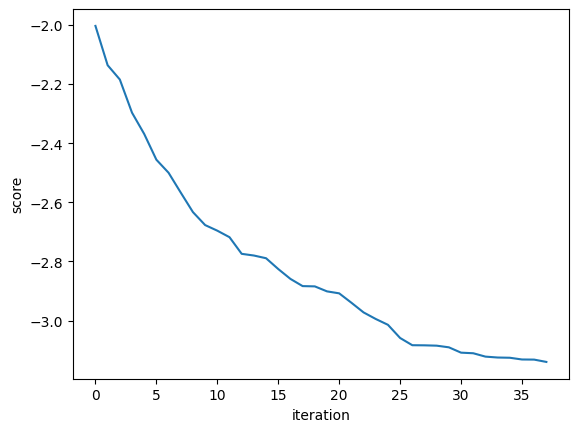

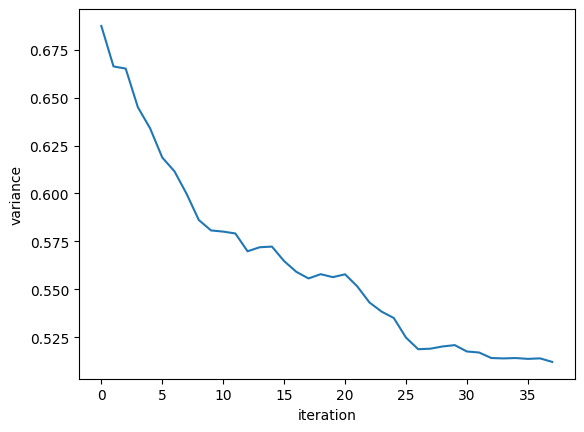

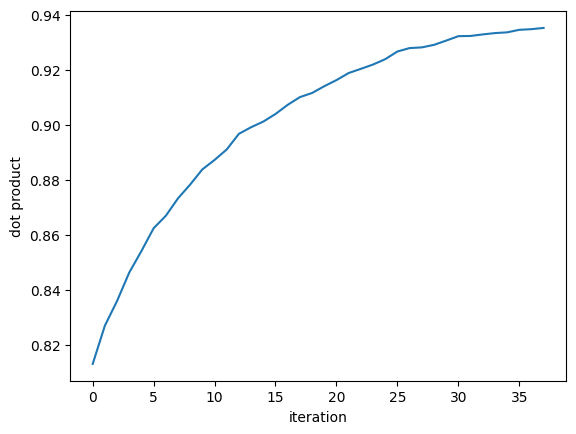

In [124]:
#@title save and plot

# write score in file
df = pd.DataFrame([scorePlot, varPlot, dotPlot])
# put the index and header
df.index = ['score', 'variance', 'dot product']
df.columns = [str(i) for i in range(len(scorePlot))]
# write in file
df.to_csv('score.csv', index=True, header=True)

#plot score
plt.plot(scorePlot)
plt.ylabel('score')
plt.xlabel('iteration')
plt.show()

#plot variance
plt.plot(varPlot)
plt.ylabel('variance')
plt.xlabel('iteration')
plt.show()

#plot dot product
plt.plot(dotPlot)
plt.ylabel('dot product')
plt.xlabel('iteration')
plt.show()

In [125]:
#@title Save File

# write matrix of allocation in file
df = pd.DataFrame(SellectedMatrixBest)
# put the index and header
df.index = [str(Stds[i]) for i in range(nStd)]
df.columns = [str(Tchs[i]) for i in range(nTch)]
# write in file
df.to_csv('SellectedMatrixBest.csv', index=True, header=True)

In [126]:
# allocated in object
for i in range(nStd):
    for j in range(nTch):
        if SellectedMatrixBest[i][j] == 1:
            Stds[i].allocate(Tchs[j])

# Time allocation

In [127]:
#@title Parametros
sectionsTime = [1, 2, 3, 4]
Timeoutsideloop = 50000
Timeinsideloop = 1
nSections = len(sectionsTime)
nStdsPerSection = math.ceil(nStd / nSections)

In [128]:
#@title Func to calculate the score of the time allocation
def timeAllocScore(timeAlloc):
    # calculate the score of the time allocation
    tchTimeScore = 0
    for t in range(nTch):
        tchTimeScore += 10**(timeAlloc[t] - 1)
    return tchTimeScore

In [129]:
# create a matrix of time and students
TimeAlloc = np.array([[0 for _ in range(nTch)] for _ in range(nStd)])
for s in range(nStd):
    for t in range(nTch):
        if SellectedMatrixBest[s][t] == 1:
            TimeAlloc[s][t] = (s // nStdsPerSection) + 1

print(TimeAlloc)

score = timeAllocScore([len(set(TimeAlloc[:,i]))-1 for i in range(nTch)])
flag = 0

count = [0 for _ in range(nSections)]

for teacher in range(nTch):
    secs = [elem[0] for elem in Tchs[teacher].section]
    nsec = len(set(secs))
    count[nsec-1] += 1

print(count)


# # swap students in the time allocation
for loop in range(Timeoutsideloop):

    aux = copy.deepcopy(TimeAlloc)

    # count how many different number in each collum
    for i in range(Timeinsideloop):

        # select from random collum with weights given by
        weight = [(len(set(aux[:,t]))-1) for t in range(nTch)]
        # wich collum
        t = r.choices(range(nTch), weights=weight, k=1)[0]

        nDiff = len(set(aux[:,t]))-1

        if nDiff == 1:
            continue

        # select a random student from the collum
        idx = [s for s in range(nStd) if aux[s][t] != 0]

        # set frequencies
        freq = [0 for _ in range(nSections)]
        for id in idx:
          freq[(aux[id][t] - 1)] = freq[(aux[id][t] - 1)] + 1

        freq_nonzero = np.nonzero(freq)

        selected_std = r.choice(idx)
        selected_time = aux[selected_std][t]

        # select another random student from the collum
        idx = [s for s in range(nStd) if (aux[s][t] != selected_time and aux[s][t] != 0)]
        swap_std = r.choice(idx)
        swap_time = aux[swap_std][t]

        # in line of the selected student, change the time
        aux[selected_std] = [swap_time if x == selected_time else x for x in aux[selected_std]]
        # in line of the swap student, change the time
        aux[swap_std] = [selected_time if x == swap_time else x for x in aux[swap_std]]

    score_new = timeAllocScore([len(set(aux[:,t]))-1 for t in range(nTch)])
    flag += 1

    # if the score is better, keep the new matrix
    if score_new < score:
        score = score_new
        TimeAlloc = copy.deepcopy(aux)
        flag = 0
    elif flag > 2000:
        Timeinsideloop += 1
        flag = 0
    elif Timeinsideloop > 10:
        break

# alloc times in classes
for student in range(nStd):
    for teacher in range(nTch):
        if SellectedMatrixBest[student][teacher] == 1:
            # allocate the student in the class
            Stds[student].addSection(TimeAlloc[student][teacher], Tchs[teacher])

[[1 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[0, 0, 0, 100]


In [ ]:
#@title save the time allocation in a file
df = pd.DataFrame(TimeAlloc)
# put the index and header
df.index = [str(Stds[i]) for i in range(nStd)]
df.columns = [str(Tchs[i]) for i in range(nTch)]
# write in file
df.to_csv('TimeAlloc.csv', index=True, header=True)

In [130]:
#@title visualize results

sectionsAlloc = [[[],[]] for _ in range(nSections)]

# Organize the students by time of section
for student in range(nStd):
    sectionsAlloc[(Stds[student].section[0] - 1)][0].append(student)

# Organize the referees by time of section
for teacher in range(nTch):
    for sec in Tchs[teacher].section:
        sectionsAlloc[(sec[0] - 1)][1].append(teacher)

for tsection in range(nSections):
    sectionsAlloc[tsection][1] = list(set(sectionsAlloc[tsection][1]))

# write as dataframe
df = pd.DataFrame(sectionsAlloc)
# put the index and header
df.index = [str(i) for i in range(nSections)]
df.columns = ['students', 'teachers']
# write in file
df.to_csv('sectionsAlloc.csv', index=True, header=True)

# plot the results
# for tsection in range(nSections):
#     print('Section ' + str(tsection + 1))
#     print('Students:')
#     for student in sectionsAlloc[tsection][0]:
#         print(Stds[student])
#     print('Teachers:')
#     for teacher in sectionsAlloc[tsection][1]:
#         print(Tchs[teacher])
#     print('\n')

# count how many sections for each teacher
count = [0 for _ in range(nTch)]
for teacher in range(nTch):
    for student in range(nStd):
        if SellectedMatrixBest[student][teacher] == 1:
            count[teacher] += 1

# count how many teacher have each number of sections
count = [0 for _ in range(nSections)]

for teacher in range(nTch):
    secs = [elem[0] for elem in Tchs[teacher].section]
    nsec = len(set(secs))
    count[nsec-1] += 1

print(count)



[3, 56, 41, 0]
